# Is Sympy really 'slow'?
I don't want to be a bad carpenter who blames his tools. Here're my attempts at understanding why my Sympy code is slow. The technical specs of my computer may have a lot to do with the long time things are taking to run, though, any techniques I discover to speed up computation will have a speed up on any system I suppose. 

Ultimately my goal is to have integral and linear algebra routines that can run at sub-second speed, and preferrably a few ms. 

## Potential things to try out 

* ~~I may have been using the wrong Python version of Theano. The [docs](https://theano-pymc.readthedocs.io/en/latest/requirements.html) say official support for Theano is only there for Python <3.6.~~ 
    * ~~install Sympy, Theano nd pyMC3~~ *This doesn't work because Theano didn't seem to recognise 'external' sympy functions, eg. legendre*
    
* With ```lambdify``` use the 'mpmath' module as a backend. This *really* sped up computations, in comparison to the default (sympy?) backend module. 

* ~~Linux specific: change the 'niceness'of the process and so the CPU spends more time on the code.~~~

## Latest realisation
* I've been using the 'normal' Hankel function instead of the spherical Hankel function. This is probably the main reason why my results are off all the time!!!!!

In [1]:
#from joblib import Parallel, delayed
#from joblib import wrap_non_picklable_objects
from gmpy2 import *
import matplotlib.pyplot as plt
import mpmath
from mpmath import mpf
dps = 30; mpmath.mp.dps = dps
import numpy as np
#from scipy.special import jv as bessel_firstkind
from symengine import * 
import sympy
from sympy import jn,yn ,symbols, legendre, sin, cos, tan, summation, I, oo, diff, pi, sqrt
from sympy import factor_terms, Matrix, besselj, bessely, Piecewise
from sympy import Abs, lambdify, integrate, expand,integrate, Integral
from sympy.printing.theanocode import theano_function
from sympy.utilities.autowrap import autowrap
#import tqdm
x, alpha, gamma, index, k, m,n,p, r1, R, theta, y, z = symbols('x alpha gamma index k m n p r1 R theta,y,z')
from sympy import N, cse

from sympy.printing.theanocode import theano_function
num_sumterms = 50

In [2]:
from sympy import besselj

In [3]:
I*yn(10,0.5)

I*yn(10, 0.5)

In [4]:
o = (pi/(2*z))**0.5

In [5]:
sph_bessel1 = besselj(n+1/2,z)*(pi/(2*z))**0.5
sph_bessel2 = bessely(n+1/2,z)*(pi/(2*z))**0.5
sph_hankel2 = sph_bessel1 - I*sph_bessel2
#sph_hankel2 = lambdify([n, p], sph_bessel1(n,p)-I*sph_bessel2(n,p), 'mpmath')

In [6]:
sph_bessel2

0.707106781186548*pi**0.5*(1/z)**0.5*bessely(n + 0.5, z)

In [7]:
r1 = (R*cos(alpha))/cos(theta)

In [8]:
subs_dict = {'alpha':mpmath.pi/18, 'k':5,'R':mpf(0.1), 'm':20,'n':10}

In [9]:
Lm_expr = legendre(m,cos(theta))*(r1**2/R**2)*tan(theta)

Lm = Integral(Lm_expr, (theta,0,alpha)).as_sum(50)#.doit(meijerg=True)

In [10]:
Lmexpr_func = lambdify([m, R, alpha,theta], Lm_expr, 'mpmath')
Lm_func = lambdify([m, R, alpha], Lm, 'mpmath')

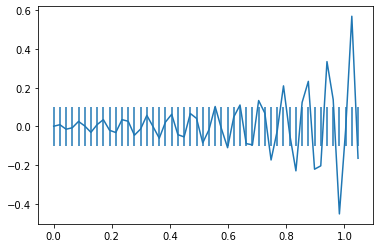

In [11]:
thetas = np.linspace(0,np.pi/3,50)
lmfunc = [Lmexpr_func(80,subs_dict['R'],subs_dict['alpha'],each) for each in thetas]
plt.figure()
plt.plot(thetas, lmfunc)
plt.vlines(thetas,-0.1,0.1)

In [12]:
%%time
Lm.subs(subs_dict)

CPU times: user 632 ms, sys: 9.49 ms, total: 641 ms
Wall time: 649 ms


0.000810729079028382075155147555668

In [13]:
# eqn 12.107
Kmn_expr = legendre(n, cos(theta))*legendre(m, cos(theta))*sin(theta)
#Kmn = Integral(Kmn_expr, (theta, alpha, pi))#.as_sum(num_sumterms,'midpoint')

In [38]:
legendre_1stderiv = diff(legendre(n,z),z)
# when m != n
num_legendre_term1 = legendre(m,cos(alpha))*legendre_1stderiv.subs({'z':cos(alpha)})
num_legendre_term2 = legendre(n,cos(alpha))*legendre_1stderiv.subs({'n':m,'z':cos(alpha)})
eqn70_mnoteqn = sin(alpha)*(num_legendre_term1-num_legendre_term2)/(m*(m+1)-n*(n+1))
#
summn_funcn1 = legendre(index,cos(alpha)) 
summn_funcn2 = legendre(index,cos(alpha))*cos(alpha)-legendre(index+1,cos(alpha))
summn_funcn = summn_funcn1*summn_funcn2
# substituting 'j' for 'index' because j is also used for sqrt(-1) all through the book!!

# --- THERE'S PROBABLY AN ERROR IN THE M==N CASE BECAUSE THE SUMMATION GOES FROM 1 -- M-1 , AND W
# THEN THE SUMMATION IS FROM 1 -- 0. NEED TO CHECK IF THE NEW VERSION ALSO HAS THIS WEIRD TERM?
meqn_sumterm = 2*summation(summn_funcn, (index,1,m-1))
eqn70_meqn = (1+ cos(alpha)*legendre(m,cos(alpha))**2 + meqn_sumterm)/(2*m+1)

In [39]:
eq70 = lambdify([m,alpha], eqn70_meqn, 'mpmath')

In [54]:
kmnnn = Piecewise((1,m==n),(2,m!=n))
kmn2f = lambdify([m,n],kmnnn)

In [58]:
2==2

True

In [57]:
kmn2f(2,2)

2

In [17]:
Kmn = Piecewise((eqn70_meqn,m==n), (eqn70_mnoteqn,m!=n))
Kmn_func = lambdify([m,n,alpha],Kmn,'mpmath')

In [28]:
eqn70_meqn.subs({'m':1,'n':1,'alpha':pi/10})

2*Sum((sqrt(sqrt(5)/8 + 5/8)*legendre(index, sqrt(sqrt(5)/8 + 5/8)) - legendre(index + 1, sqrt(sqrt(5)/8 + 5/8)))*legendre(index, sqrt(sqrt(5)/8 + 5/8)), (index, 1, 0))/3 + (sqrt(5)/8 + 5/8)**(3/2)/3 + 1/3

In [33]:
eqn70_mnoteqn.subs({'m':2,'n':1,'alpha':pi/10})

(-1/4 + sqrt(5)/4)*(-2*sqrt(sqrt(5)/8 + 5/8)*(-sqrt(sqrt(5)/8 + 5/8) + sqrt(sqrt(5)/8 + 5/8)*(3*sqrt(5)/16 + 7/16))/(-3/8 + sqrt(5)/8) + 3*sqrt(5)/16 + 7/16)/4

In [37]:
summation(index*x**2,(index,1,-5))

10*x**2

In [49]:
Kmn_func(2,2,0.5)

ZeroDivisionError: 

In [58]:
Kmn_func(5,4,0.1)

mpf('-0.0470089106701610975465929259350054')

In [60]:
Kmn_func(4,4,0.1)

ZeroDivisionError: 

In [51]:
>>> f = x**2
>>> g = log(x)
>>> p = Piecewise((0, x < -1), (f, x <= 1), (g, True))
>>> p.subs(x,1)
1


1

In [24]:
Kmn

Integral(sin(theta)*legendre(m, cos(theta))*legendre(n, cos(theta)), (theta, alpha, pi))

In [9]:
sph_hankel2.subs({'n':n-1})

0.707106781186548*pi**0.5*(1/z)**0.5*besselj(n - 0.5, z) - 0.707106781186548*I*pi**0.5*(1/z)**0.5*bessely(n - 0.5, z)

In [10]:
sph_hankel2

0.707106781186548*pi**0.5*(1/z)**0.5*besselj(n + 0.5, z) - 0.707106781186548*I*pi**0.5*(1/z)**0.5*bessely(n + 0.5, z)

In [11]:
n*sph_hankel2.subs({'n':n-1, 'z':k*r1})

n*(0.707106781186548*pi**0.5*(cos(theta)/(R*k*cos(alpha)))**0.5*besselj(n - 0.5, R*k*cos(alpha)/cos(theta)) - 0.707106781186548*I*pi**0.5*(cos(theta)/(R*k*cos(alpha)))**0.5*bessely(n - 0.5, R*k*cos(alpha)/cos(theta)))

In [13]:
pt1_postterm = legendre(n,cos(theta))*cos(theta)
alternate_hankels = n*sph_hankel2.subs({'n':n-1, 'z':k*r1})-(n+1)*sph_hankel2.subs({'n':n+1, 'z':k*r1})
Imn_pt1 = alternate_hankels*pt1_postterm

pt2_preterm = n*(n+1)*sph_hankel2.subs({'z':k*r1})
alternate_legendres = pt2_preterm*(legendre(n-1,cos(theta))-legendre(n+1,cos(theta)))/(k*r1)
Imn_pt2 = pt2_preterm*alternate_legendres


whole_postterm = legendre(m,cos(theta))*(r1**2/R**2)*tan(theta)

Imn_term = (Imn_pt1 + Imn_pt2)*whole_postterm
#Imn = Integral(Imn_term,(theta,0,alpha)).as_sum(50)
Imn = Integral(Imn_term,(theta,0,alpha)).as_sum(100)
# Imn_part2 = n*(n+1)*sph_hankel2(n, k*r1)*(legendre(n-1, cos(theta)-legendre(n+1, cos(theta))))/k*r1
#Imn_parts = expand(Imn_part1+Imn_part2)
#Imn_expr = expand(sympy.simplify(Imn_parts*legendre(m,cos(theta))*(r1**2/R**2)*tan(theta)))
#Imn = Integral(Imn_expr, (theta, 0, alpha))#.doit(meijerg=True)
Imn_term_func = lambdify([m,n,k,R,alpha,theta], Imn_term, 'mpmath')
Imn_func = lambdify([m,n,k,R,alpha],Imn,'mpmath')
#Imn2_func = lambdify([m,n,k,R,alpha],Imn2,'mpmath')

In [14]:
mv,nv = 10,50
npts = 100
imn_values = mpmath.matrix(1,npts)
angles = np.linspace(0,float(subs_dict['alpha']),npts)
for i,each in enumerate(angles):
    imn_values[i] = Imn_term_func(mv,nv,subs_dict['k'],subs_dict['R'],subs_dict['alpha'],each)
real_imn = [each.real for each in imn_values]
imag_imn = [each.imag for each in imn_values]
abs_imn = [abs(each) for each in imn_values]

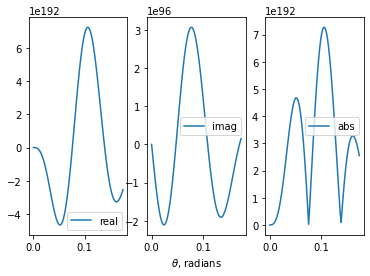

In [15]:
plt.figure()
plt.subplot(131)
plt.plot(angles, real_imn,label='real');plt.legend()
plt.subplot(132)
plt.plot(angles, imag_imn,label='imag');plt.legend()
plt.xlabel('$\\theta$, radians')
plt.subplot(133)
plt.plot(angles, abs_imn,label='abs');plt.legend()


### Broadly speaking, the Imn function is fairly smooth, and so numerical integration shouldn't be such a problem?

In [31]:
M_mn = (Imn + (n*sph_hankel2(n-1,k*R) - (n+1)*sph_hankel2(n+1,k*R) )*Kmn)/(2*n+1)



In [42]:
M_mn_func = lambdify((m,n,k,R,alpha), M_mn,'sympy')

In [34]:
b = -I*Lm
b_func = lambdify([m,alpha], b,'mpmath')

In [35]:
frequency = 50*10**3 # kHz
vsound = 330 # m/s
wavelength = vsound/frequency
alpha_value = np.radians(60)
k_value = 2*np.pi/(wavelength)
ka = 5
a_value = ka/k_value 
R_value = a_value/mpmath.sin(alpha_value) # m


In [36]:
Nv = 12 + int(2*ka/sin(alpha_value))
M_matrix = mpmath.matrix(Nv,Nv)
b_matrix = mpmath.matrix(Nv,1)


In [37]:
params = {'k':k_value, 'a':a_value, 'R':R_value, 'alpha':alpha_value}

In [ ]:
M_mn_func

In [39]:
%%time
Mmn(0,1,params)

CPU times: user 105 ms, sys: 70 µs, total: 105 ms
Wall time: 104 ms


KeyboardInterrupt: 

In [25]:
help(mpmath.lu_solve)

Help on method lu_solve in module mpmath.matrices.linalg:

lu_solve(A, b, **kwargs) method of mpmath.ctx_mp.MPContext instance
    Ax = b => x
    
    Solve a determined or overdetermined linear equations system.
    Fast LU decomposition is used, which is less accurate than QR decomposition
    (especially for overdetermined systems), but it's twice as efficient.
    Use qr_solve if you want more precision or have to solve a very ill-
    conditioned system.
    
    If you specify real=True, it does not check for overdeterminded complex
    systems.



In [26]:
for each_m in range(Nv):
    #M_matrix[each_m, each_n] = M_mn_func(each_m, each_n, k_value, R_value, alpha_value)
    b_matrix[each_m,:] = b_func(each_m, alpha_value)


In [27]:
#a_matrix = mpmath.lu_solve(M_matrix,b_matrix)
a_matrix,res = mpmath.qr_solve(M_matrix,b_matrix)

ValueError: matrix is numerically singular

In [ ]:
mpmath.residual(M_matrix,a_matrix,b_matrix)

In [ ]:
legendre_func = lambdify((m, x), legendre(m, x),'mpmath')

In [ ]:

def d_theta(angle,k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.rows
    denom  = (k_v**2)*(R_v**2)*mpmath.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    legendre_matrix = np.array([legendre(n_v, np.cos(angle)) for n_v in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix, legendre_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1]*X[2], 1, part2_matrix))
    rel_level = - part1*part2
    return rel_level

def d_zero(k_v,R_v,alpha_v,An):
    num = 4 
    N_v = An.rows
    denom  = (k_v**2)*(R_v**2)*mpmath.sin(alpha_v)**2
    part1 = num/denom
    jn_matrix = np.array([1j**f for f in range(N_v)])
    part2_matrix = np.column_stack((An, jn_matrix))
    part2 = np.sum(np.apply_along_axis(lambda X: X[0]*X[1], 1, part2_matrix))
    rel_level = - part1*part2
    return rel_level

def relative_directionality_db(angle,k_v,R_v,alpha_v,An):
    off_axis = d_theta(angle,k_v,R_v,alpha_v,An)
    on_axis = d_zero(k_v,R_v,alpha_v,An)
    rel_level = 20*mpmath.log10(abs(off_axis/on_axis))
    return rel_level

In [ ]:

angles = np.linspace(0,2*np.pi,200)
dirnlty = [relative_directionality_db(angle_v, k_value, R_value,alpha_value,a_matrix) for angle_v in angles]


In [ ]:
plt.figure()
a0 = plt.subplot(111, projection='polar')
plt.plot(angles, dirnlty)
plt.ylim(-40,0);plt.yticks([0,-10,-20,-30,-40]);
plt.xticks(np.radians(np.arange(0,360,30)));